# Word Embedding avec WORD2VEC un exemple

## En-tête

In [1]:
import math
import warnings
warnings.filterwarnings(action = 'ignore')

## Gestion des données

### Récupération des données

In [2]:
import pandas as pd
import numpy as np
import math

data = pd.read_csv('data/all_lyrics.csv')
lyrics = data['lyrics']

# Suppression des valeurs NaN
lyrics = [x for x in lyrics if pd.isnull(x) == False and x != "nan"]

# Suppression de sons inutiles 
suppression = [733, 3305, 3411, 3466, 3778]
new_lyrics  = [song for index, song in enumerate(lyrics) if index not in suppression]
lyrics = new_lyrics

### Pré-traitement

In [3]:
import re 

"""onomatopee = ["shh", "shhh", "ouch", "yum", "ugh", "glug", "huh", "wa", "waa", "wo", 
              "oh", "ohh", "wow", "phew", "hmm", "ooo", "eee", "tic", "toc", "aye", 
              "ay", "bb"]"""

def pretraitement(song):
    # Suppression des texts entre crochets, des backs entre parenthèses
    song = re.sub(r'\[.*?\]', '', song)
    song = re.sub(r'\(.*?\)', '', song)
    song = re.sub(r'\'.*?\'', '', song)

    # Suppression de la première ligne et des lignes vides
    lines = song.splitlines()
    lines = [line for line in lines if line.strip() != ""]
    song = "\n".join(lines[1:])

    # Mise en minuscule et suppression de la ponctuation
    song = song.lower()
    song = ''.join(char for char in song if (char not in '/},.!)(;%$=+-#&?*":{') and (char not in "'"))

    # Remplacement des tirets
    song = song.replace('-', ' ')

    # Remplacement des multi-espaces par un seul 
    song = re.sub(r'\s+', ' ', song)

    # Suppression des onomatoppées 
    #for word in onomatopee:
        #song = song.replace(" " + word + " ", '')

    # Remplacement de certaines abréviation en anglais 
    song = song.replace("'ll", " will")
    song = song.replace("'ve", " have")
    song = song.replace("'s", " is")
    song = song.replace("'re", " are")
    song = song.replace("'m", " am")

    # Transformation en tableau
    song = song.split()

    # Suppression du ..Embed à la fin de chaque son
    if len(song) > 0: 
        if 'embed' in song[-1]: song[-1] = song[-1].replace('embed', '')

    # Suppression des nombres
    song = [word.replace('0', '').replace('1', '').replace('2', '').replace('3', '').replace('4', '').replace('5', '').replace('6', '').replace('7', '').replace('8', '').replace('9', '') for word in song]

    return song


In [4]:
# Création du Bag Of Word qu'on utilisera dans nos modèles
BagOfWord = []

for song in lyrics:
    pretraited_song = pretraitement(song)
    BagOfWord.append(pretraited_song)

## Word2Vec

### Importation du modèle

In [5]:
import gensim
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

### Entraînement

#### Grid-Search

##### Logger

In [6]:
class LossLogger(CallbackAny2Vec):
    '''Output loss at each epoch'''
    def __init__(self):
        self.epoch = 1
        self.losses = []

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        self.losses.append(loss)
        self.epoch += 1

##### Fonction principale

In [7]:
import sys
import time

def GridSearch(Parameters, sg=0):
    # Initialisation des paramètres
    Grid_Search = {}
    last_loss   = math.inf
    # Total de combinaison à tester
    nombre_combinaison = len(Parameters['WINDOW']) * len(Parameters['NEGATIVES']) * len(Parameters['MIN_COUNT']) * len(Parameters['VECTOR_SIZE']) * len(Parameters['EPOCHS'])
    # Début de la recherche des meilleurs paramètres
    etape = 1
    start_time = time.time()
    for w in Parameters['WINDOW']:
        for n in Parameters['NEGATIVES']:
            for m in Parameters['MIN_COUNT']:
                for v in Parameters['VECTOR_SIZE']:
                    for e in Parameters['EPOCHS']:
                        # Définition de la méthode d'entraînement
                        if n <= 0: hs=True
                        else:     hs=False 
                        # Initialisation du Logger
                        loss_loger = LossLogger()
                        # Copie des valeurs des paramètres
                        params = {"WINDOW": w, 
                                "NEGATIVES": n, 
                                "MIN_COUNT": m, 
                                "VECTOR_SIZE": v,
                                "EPOCHS": e}
                        # Entraînement du modèle
                        model = gensim.models.Word2Vec(BagOfWord, 
                                                    epochs=e, 
                                                    min_count=m, 
                                                    vector_size=v, 
                                                    window=w, 
                                                    negative=n,
                                                    hs=hs,
                                                    callbacks=[loss_loger], 
                                                    compute_loss=True, 
                                                    sg=sg)
                        # Récupération et enregistrement de la fonction de coût
                        loss = model.get_latest_training_loss()
                        params_key = (w, n, m, v, e)
                        Grid_Search[params_key] = loss_loger.losses
                        # Le modèle créé est meilleur que l'ancien
                        if loss < last_loss:
                            Grid_Search["best_estimator_"] = model 
                            Grid_Search["best_params_"]    = params
                            last_loss = loss
                        # Actualisation de la barre de progression 
                        end_time = time.time()
                        pourcentage = etape/nombre_combinaison
                        progress = int(50*pourcentage)
                        estimation = (nombre_combinaison*(end_time - start_time))/(etape)
                        barre = "#"*progress + "."*(50-progress)
                        sys.stdout.write(f"\r[{barre}] {int(pourcentage * 100)}% Temps d'éxecution: {(end_time - start_time):.2f}s  ETA: {estimation:.2f}s")
                        sys.stdout.flush()
                        etape += 1
                        # Remise à 0 du modèle 
                        model = None
                        
    return Grid_Search

#### CBOW

##### Recherche du meilleur modèle

In [8]:
# Paramètres à tester pour le modèle CBOW
PARAMS_CBOW = {
    "WINDOW":      [2, 5, 10],
    "NEGATIVES":   [0],
    "MIN_COUNT":   [5],
    "VECTOR_SIZE": [100, 500, 1000],
    "EPOCHS":      [1, 2, 5]
}

grid_search_cbow = GridSearch(Parameters=PARAMS_CBOW, sg=0)

[##################################################] 100% Temps d'éxecution: 218.69s  ETA: 218.69s

###### Récupération et affichage du meilleur modèle

In [9]:
CBOW = grid_search_cbow['best_estimator_']
CBOW_params = grid_search_cbow['best_params_']

print("Le meilleur modèle a les paramètres suivant : \n")
print("\tWINDOW:      " + str(CBOW_params['WINDOW']))
print("\tNEGATIVES:   " + str(CBOW_params['NEGATIVES']))
print("\tMIN_COUNT:   " + str(CBOW_params['MIN_COUNT']))
print("\tVECTOR_SIZE: " + str(CBOW_params['VECTOR_SIZE']))
print("\tEPOCHS:      " + str(CBOW_params['EPOCHS']))

Le meilleur modèle a les paramètres suivant : 

	WINDOW:      2
	NEGATIVES:   0
	MIN_COUNT:   5
	VECTOR_SIZE: 100
	EPOCHS:      1


###### Classement des meilleurs modèles

In [10]:
params_models_cbow = {}
for index, value in grid_search_cbow.items():
    if type(index) is tuple:
        params_models_cbow[index] = value

classement_cbow = dict(sorted(params_models_cbow.items(), key=lambda t: t[1][-1]))
pos=1
print("Position | WINDOW | NEGATIVES | MIN_COUNT | VECTOR_SIZE | EPOCHS |   Perte")
for index, value in classement_cbow.items():
    print(" "*3 + str(pos), end=" "*(11-len(str(pos))))
    print(str(index[0]), end=" "*(10-len(str(index[0]))))
    print(str(index[1]), end=" "*(12-len(str(index[1]))))
    print(str(index[2]), end=" "*(11-len(str(index[2]))))
    print(str(index[3]), end=" "*(10-len(str(index[3]))))
    print(str(index[4]), end=" "*(10-len(str(index[4]))))
    print(str(value[-1]), end=" "*(10-len(str(value[-1]))))
    print()
    pos+=1

Position | WINDOW | NEGATIVES | MIN_COUNT | VECTOR_SIZE | EPOCHS |   Perte
   1          2         0           5          100       1         3657245.5 
   2          5         0           5          1000      1         3694181.0 
   3          10        0           5          500       1         3710042.75
   4          5         0           5          100       1         3722658.0 
   5          5         0           5          500       1         3753821.25
   6          10        0           5          1000      1         3767101.5 
   7          2         0           5          1000      1         3773960.5 
   8          10        0           5          100       1         3787472.75
   9          2         0           5          500       1         3857938.5 
   10         2         0           5          500       2         7068997.5 
   11         10        0           5          1000      2         7143144.5 
   12         10        0           5          500       2         

#### Skip-Gram

##### Recherche du meilleur modèle

In [11]:
# Paramètres à tester pour le modèle Skip Gram
PARAMS_SG = {
    "WINDOW":      [2, 5, 10],
    "NEGATIVES":   [0],
    "MIN_COUNT":   [5],
    "VECTOR_SIZE": [100, 500, 1000],
    "EPOCHS":      [1, 2]
}

grid_search_sg = GridSearch(Parameters=PARAMS_SG, sg=1)

[##################################################] 100% Temps d'éxecution: 269.76s  ETA: 269.76s

###### Récupération et affichage du meilleur modèle

In [12]:
SkipGram = grid_search_sg['best_estimator_']
SkipGram_params = grid_search_sg['best_params_']

print("Le meilleur modèle a les paramètres suivant : \n")
print("\tWINDOW:      " + str(SkipGram_params['WINDOW']))
print("\tNEGATIVES:   " + str(SkipGram_params['NEGATIVES']))
print("\tMIN_COUNT:   " + str(SkipGram_params['MIN_COUNT']))
print("\tVECTOR_SIZE: " + str(SkipGram_params['VECTOR_SIZE']))
print("\tEPOCHS:      " + str(SkipGram_params['EPOCHS']))

Le meilleur modèle a les paramètres suivant : 

	WINDOW:      2
	NEGATIVES:   0
	MIN_COUNT:   5
	VECTOR_SIZE: 100
	EPOCHS:      1


###### Classement des meilleurs modèles

In [13]:
params_models_sg = {}
for index, value in grid_search_sg.items():
    if type(index) is tuple:
        params_models_sg[index] = value

classement_sg = dict(sorted(params_models_sg.items(), key=lambda t: t[1][-1]))
pos=1
print("Position | WINDOW | NEGATIVES | MIN_COUNT | VECTOR_SIZE | EPOCHS |   Perte")
for index, value in classement_sg.items():
    print(" "*3 + str(pos), end=" "*(11-len(str(pos))))
    print(str(index[0]), end=" "*(10-len(str(index[0]))))
    print(str(index[1]), end=" "*(12-len(str(index[1]))))
    print(str(index[2]), end=" "*(11-len(str(index[2]))))
    print(str(index[3]), end=" "*(10-len(str(index[3]))))
    print(str(index[4]), end=" "*(10-len(str(index[4]))))
    print(str(value[-1]), end=" "*(10-len(str(value[-1]))))
    print()
    pos+=1

Position | WINDOW | NEGATIVES | MIN_COUNT | VECTOR_SIZE | EPOCHS |   Perte
   1          2         0           5          100       1         11463933.0
   2          2         0           5          500       1         11666273.0
   3          2         0           5          1000      1         11708556.0
   4          5         0           5          500       1         18190374.0
   5          5         0           5          1000      1         18221470.0
   6          5         0           5          100       1         18237424.0
   7          2         0           5          1000      2         18491320.0
   8          2         0           5          100       2         18498334.0
   9          2         0           5          500       2         18569294.0
   10         10        0           5          100       1         23175916.0
   11         10        0           5          1000      1         23337026.0
   12         10        0           5          500       1         

#### Enregistrement des modèles

In [14]:
import os

chemin_cbow = "model/CBOW_final.wvmodel"
chemin_sg   = "model/SkipGram_final.wvmodel"

if os.path.exists(chemin_cbow): os.remove(chemin_cbow)
if os.path.exists(chemin_sg):   os.remove(chemin_sg)

CBOW.save(chemin_cbow)
SkipGram.save(chemin_sg)

### Evaluation

#### Chargement des modèles

In [15]:
chemin_cbow = "model/CBOW_test2.wvmodel"
chemin_sg   = "model/SkipGram_test2.wvmodel"

CBOW     = gensim.models.Word2Vec.load(chemin_sg)
SkipGram = gensim.models.Word2Vec.load(chemin_sg)

#### Mots à tester

In [16]:
# Similarité entre deux mots
word1 = 'Night'
word2 = 'Dream'
word3 = 'Light'

# Analogie
word_positive1 = 'King' 
word_positive2 = 'Woman' 
word_negative1 = 'Man' 

#### CBOW

##### Similarité entre deux mots

In [17]:
print("---------------------- Continuous Bag of Word ----------------------\n")

print("Cosine similarity between '" + word1 + "' " + "and '" + word2 + "' : ", CBOW.wv.similarity(word1.lower(), word2.lower()))
print("Cosine similarity between '" + word1 + "' " + "and '" + word3 + "' : ", CBOW.wv.similarity(word1.lower(), word3.lower()))

---------------------- Continuous Bag of Word ----------------------

Cosine similarity between 'Night' and 'Dream' :  0.803820788860321
Cosine similarity between 'Night' and 'Light' :  0.2662186


##### Analogies

In [18]:
cbow_analogie = CBOW.wv.most_similar(positive=[word_positive1.lower(), word_positive2.lower()], negative=word_negative1.lower(), topn=20637)

print("----------- Continuous Bag of Word -----------")
print("\nClassement |     Mot     | Cosine similarity\n")
for i, elem in enumerate(cbow_analogie): 
    if (i < 10) or (i >= len(cbow_analogie)-3):
        print(str(i+1), end=(" "*(12-len(str(i+1)))))
        print(elem[0][0].upper() + elem[0][1:], end=(" "*(15-len(elem[0]))))
        print(str(elem[1]))
    elif i==10: print("...")

----------- Continuous Bag of Word -----------

Classement |     Mot     | Cosine similarity

1           Gypsy          1.067075952887535
2           Heartlessheartless1.039658561348915
3           Swimming       1.026090532541275
4           Innocencebest  1.0075660049915314
5           Pneumonia      1.0027523338794708
6           Barbeque       0.9962794184684753
7           Raindrops      0.968414768576622
8           Swagger        0.9643548727035522
9           Bandits        0.9444192796945572
10          Sgt            0.935639962553978
...
20524       Quick          -0.7741958647966385
20525       Over           -0.8084478229284286
20526       Paasch         -0.8170994371175766


#### Skip-Gram

##### Similarité entre deux mots

In [19]:
print("--------------------------- Skip Gram -----------------------------\n")

print("Cosine similarity between '" + word1 + "' " + "and '" + word2 + "' : ", SkipGram.wv.similarity(word1.lower(), word2.lower()))
print("Cosine similarity between '" + word1 + "' " + "and '" + word3 + "' : ", SkipGram.wv.similarity(word1.lower(), word3.lower()))

--------------------------- Skip Gram -----------------------------

Cosine similarity between 'Night' and 'Dream' :  2.411462366580963
Cosine similarity between 'Night' and 'Light' :  0.2662186


##### Analogie

In [20]:
skip_gram_analogie = SkipGram.wv.most_similar(positive=[word_positive1.lower(), word_positive2.lower()], negative=word_negative1.lower(), topn=20637)

print("\n\n----------------- Skip Gram ------------------")
print("\nClassement |     Mot     | Cosine similarity\n")
for i, elem in enumerate(skip_gram_analogie): 
    if (i < 10) or (i >= len(skip_gram_analogie)-3):
        print(str(i+1), end=(" "*(12-len(str(i+1)))))
        print(elem[0][0].upper() + elem[0][1:], end=(" "*(15-len(elem[0]))))
        print(str(elem[1]))
    elif i==10: print("...")



----------------- Skip Gram ------------------

Classement |     Mot     | Cosine similarity

1           Swimming       1.64174485206604
2           Cherry         1.4677934646606445
3           Sixpack        1.4586939811706543
4           Beautiful      1.456878662109375
5           Magic          1.4562993049621582
6           Sous           1.4524449110031128
7           Ev             1.4501100778579712
8           Sonic          1.4470951557159424
9           Demise         1.4451097249984741
10          Herbie         1.4449055194854736
...
20524       Quick          -1.2387133836746216
20525       Over           -1.2935165166854858
20526       Paasch         -1.3073590993881226


##### Fonction de coût

In [21]:
for index, value in grid_search_sg.items():
    if type(index) is tuple:
        print(str(index) + " : " + str(value))

(2, 0, 5, 100, 1) : [11463933.0]
(2, 0, 5, 100, 2) : [11041555.0, 18498334.0]
(2, 0, 5, 500, 1) : [11666273.0]
(2, 0, 5, 500, 2) : [11289904.0, 18569294.0]
(2, 0, 5, 1000, 1) : [11708556.0]
(2, 0, 5, 1000, 2) : [11353449.0, 18491320.0]
(5, 0, 5, 100, 1) : [18237424.0]
(5, 0, 5, 100, 2) : [18536814.0, 25228112.0]
(5, 0, 5, 500, 1) : [18190374.0]
(5, 0, 5, 500, 2) : [18585876.0, 25414966.0]
(5, 0, 5, 1000, 1) : [18221470.0]
(5, 0, 5, 1000, 2) : [18581220.0, 25474282.0]
(10, 0, 5, 100, 1) : [23175916.0]
(10, 0, 5, 100, 2) : [25117276.0, 33789476.0]
(10, 0, 5, 500, 1) : [23355102.0]
(10, 0, 5, 500, 2) : [25010230.0, 33782768.0]
(10, 0, 5, 1000, 1) : [23337026.0]
(10, 0, 5, 1000, 2) : [25400140.0, 33870816.0]


#### Données sur le vocabulaire

In [22]:
vocab_len = len(SkipGram.wv)
print('Nombre de mot appris par les modèles : ' + str(vocab_len))

Nombre de mot appris par les modèles : 20542


In [23]:
print(CBOW.wv.key_to_index['woman'])
print(CBOW.wv.get_vecattr("random", "count"))

187
41


In [24]:
print(lyrics[1869])

Young Lyrics[Verse 1]
Looking back now, well it makes me laugh
We were growing our hair, we were cutting class
Knew it all already, there was nothing to learn
We were striking matches just to watch them burn
Listen to our music just a little too loud
We were hanging in there with the outcast crowd
Heading to the rapids with some discount beer
It was a long train tussle but we had no fear

[Chorus]
Man I don't know, where the time goes
But it sure goes fast, just like that
We were want to be rebels who didn't have a clue
With our Rock n roll T-shirts, and our typically bad attitudes
Had no excuses for the things that we'd done
We were brave, we were crazy, and we were mostly
Young
[Verse 2]
Talked a good game when we were out with the guys
But in the back seat we were awkward and shy
Girls were a mystery that we couldn't explain
And I guess there are some things that are never going to change

[Chorus]
Man I don't know, where the time goes
But It sure goes fast, just like that
We were w

### Visualisation

#### Fonctions utiles

In [25]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def reduce_dimensions(model):
    # Nombre de dimension de l'espace dans lequel on va projeter les mots
    NUM_DIMENSION = 2

    # Récupération des mots et leur représentation
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # Réduction de la dimensionnalité
    tsne = TSNE(n_components=NUM_DIMENSION, random_state=0)
    vectors = tsne.fit_transform(vectors)

    # Récupération des nouvelles valeurs en 3 dimensions
    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]

    return x_vals, y_vals, labels

def plot_with_matplotlib(x_vals, y_vals, labels, selected_word, file=None):

    plt.figure(figsize=(15, 15))
    plt.scatter(x_vals, y_vals)
    
    for index in selected_word:
        plt.scatter(x_vals[index], y_vals[index], c='r')
        plt.annotate((labels[index][0].upper() + labels[index][1:]), (x_vals[index], y_vals[index]), size=20)

    if file != None:
        plt.savefig(file)

#### CBOW

###### Réduction de la dimensionnalité

In [26]:
# Réduction de la dimensionnalité
x_cbow, y_cbow, labels_cbow = reduce_dimensions(CBOW)

# Enregistrements des valeurs 
data_cbow = [x_cbow, y_cbow, labels_cbow]
with open('dimension_reduite/data_cbow.npy', 'wb') as f:
    np.save(f, data_cbow)

###### Affichage

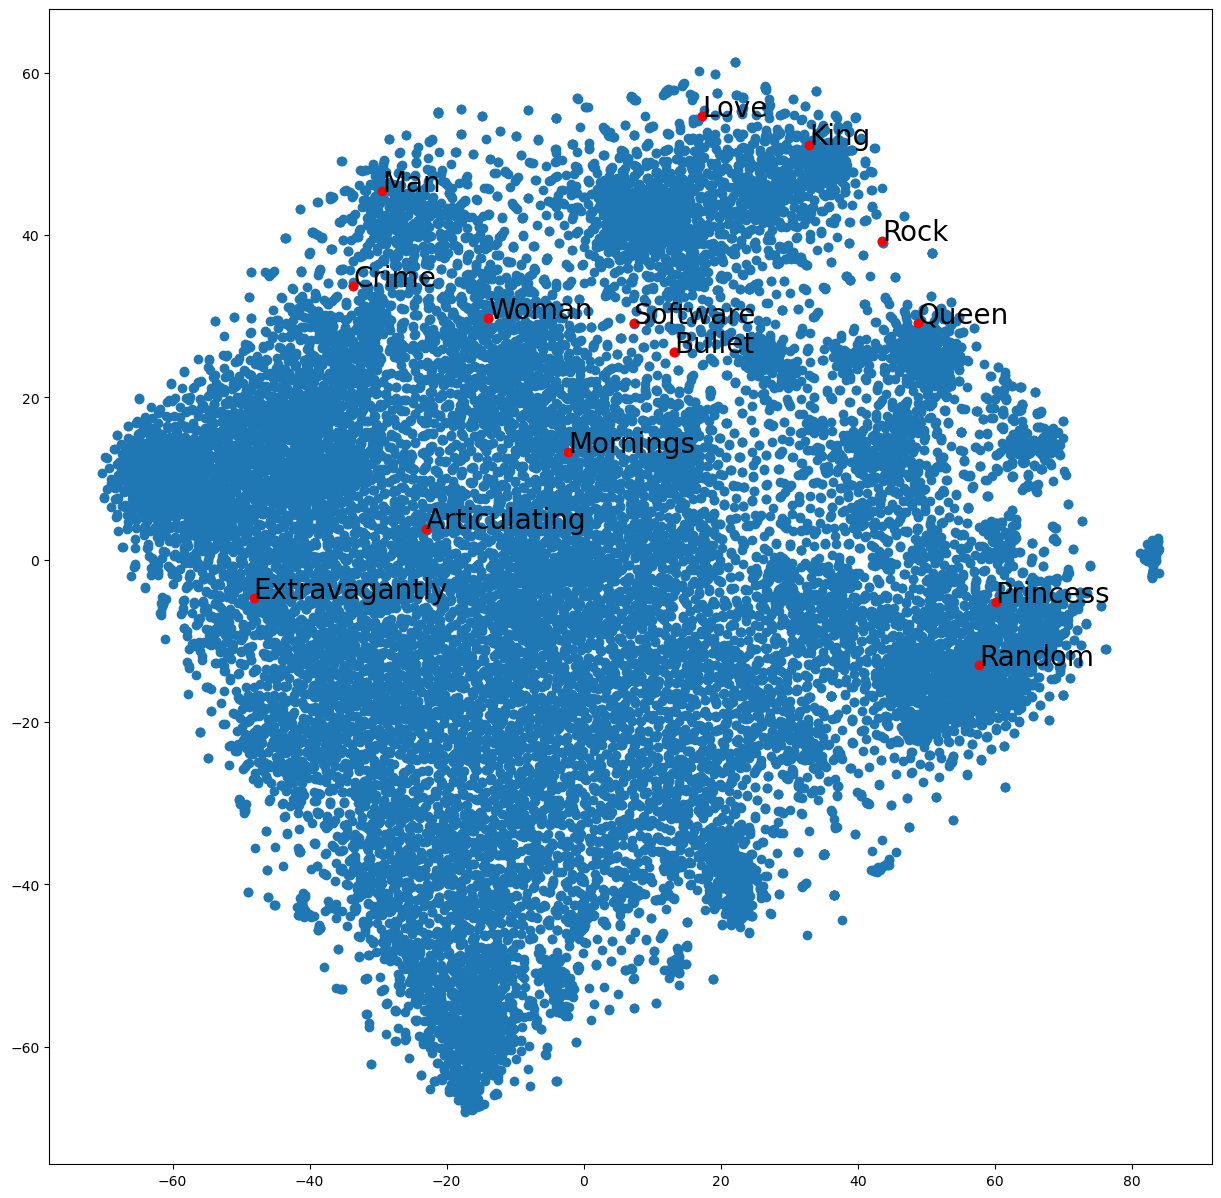

In [27]:
selected_word_cbow = [
    CBOW.wv.key_to_index["queen"],
    CBOW.wv.key_to_index["princess"],
    CBOW.wv.key_to_index["king"],
    CBOW.wv.key_to_index["man"],
    CBOW.wv.key_to_index["woman"],
    CBOW.wv.key_to_index["crime"],
    CBOW.wv.key_to_index["rock"],
    CBOW.wv.key_to_index["bullet"],
    CBOW.wv.key_to_index["random"],
    CBOW.wv.key_to_index["extravagantly"],
    CBOW.wv.key_to_index["mornings"], 
    CBOW.wv.key_to_index["software"],
    CBOW.wv.key_to_index["articulating"],
    CBOW.wv.key_to_index["love"]
]

plot_with_matplotlib(x_cbow, y_cbow, labels_cbow, selected_word_cbow, file="plot/cbow_plot.png")

#### Skip-Gram

###### Réduction de la dimensionnalité

In [28]:
x_sg, y_sg, labels_sg = reduce_dimensions(SkipGram)

In [29]:
# Enregistrements des valeurs 
data_sg = [x_sg, y_sg, labels_sg]
with open('dimension_reduite/data_sg.npy', 'wb') as f:
    np.save(f, data_sg)

###### Affichage

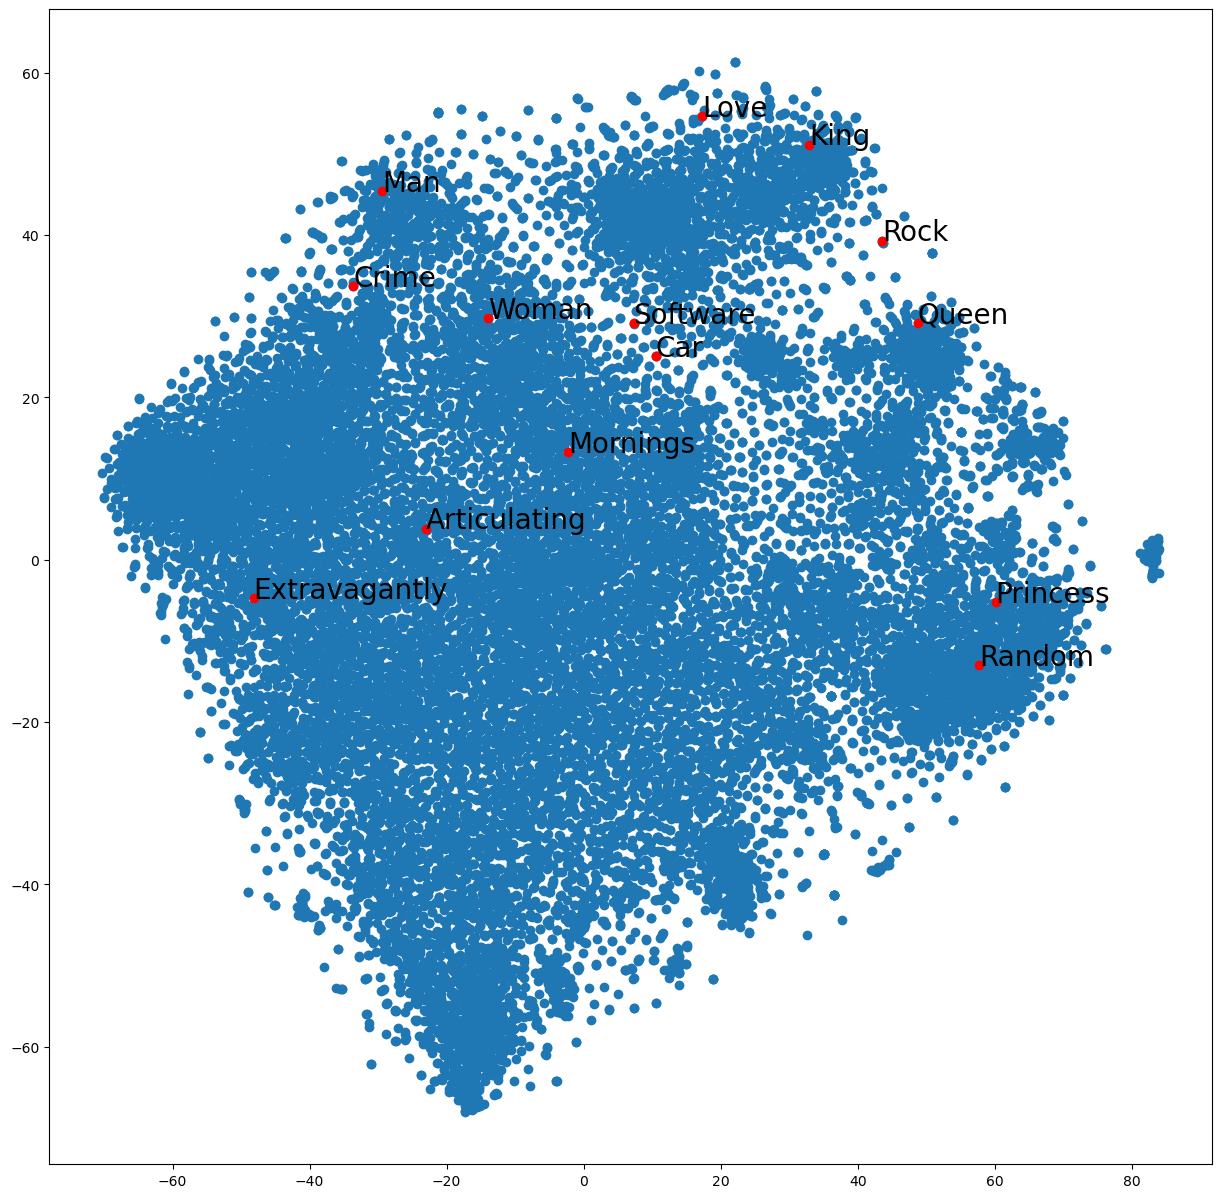

In [30]:
selected_word_sg = [
    SkipGram.wv.key_to_index["queen"],
    SkipGram.wv.key_to_index["princess"],
    SkipGram.wv.key_to_index["king"],
    SkipGram.wv.key_to_index["man"],
    SkipGram.wv.key_to_index["woman"],
    SkipGram.wv.key_to_index["crime"],
    SkipGram.wv.key_to_index["rock"],
    SkipGram.wv.key_to_index["car"],
    SkipGram.wv.key_to_index["random"],
    SkipGram.wv.key_to_index["extravagantly"],
    SkipGram.wv.key_to_index["mornings"], 
    SkipGram.wv.key_to_index["software"],
    SkipGram.wv.key_to_index["articulating"],
    SkipGram.wv.key_to_index["love"]
]

plot_with_matplotlib(x_sg, y_sg, labels_sg, selected_word_sg, file="plot/sg_plot.png")